In [1]:
import logging
import random

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.neural_ucb_bandit import NeuralUCBBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

n_samples = 100
indices = list(range(len(dataset)))
random.shuffle(indices)
subset_indices = indices[:n_samples]
mini_dataset = Subset(dataset, subset_indices)
print("Subset size:", len(mini_dataset))

7
58000
Subset size: 100


In [4]:
train_loader = DataLoader(mini_dataset, batch_size=32, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)
bandit_module = NeuralUCBBandit(
    n_features = dataset.context_size * dataset.num_actions,
    network=network,
    early_stop_threshold=1e-2,
    num_grad_steps=100,
    lambda_=0.00001,
    nu=0.00001,
    learning_rate=1e-2,
    train_freq=2,
    initial_train_steps=150,
    max_grad_norm=50.0,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="neural_ucb_bandit", flush_logs_every_n_steps=100))

In [5]:
for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    logger.pre_training_log({"regret": batch_regret})

    batch_dataloader = DataLoader(feedback, batch_size=1)
    trainer.fit(bandit_module, batch_dataloader)

Step: 6 {'training_run': 0, 'loss': 0.006282281130552292, 'reward': 1.0, 'epoch': 0, 'regret': tensor(0.)}}

c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Step: 100 {'training_run': 3, 'loss': 0.20809854567050934, 'reward': 0.0, 'epoch': 0, 'regret': tensor(1.)}

In [7]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:5000])
cumulative_regret = np.cumsum(metrics["regret"][:5000].dropna())

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

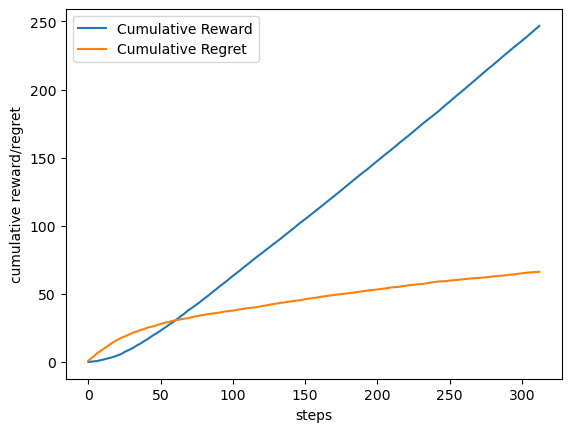

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [ ]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:313]) / 313)

print(sum(metrics["regret"][:10].dropna()) / 10)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:313].dropna()) / 313)

0.140625
0.6240625
0.7883386581469649
0.859375
0.3759375
0.21166134185303515


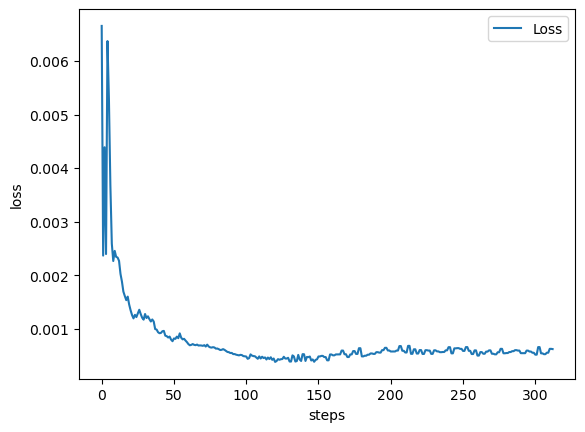

In [ ]:
plt.plot(metrics["loss"][:1000], label='Loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()